# Brain MRI Segmentation

Celem projektu jest zaprojektowanie sieci neuronowej rozwiązującej problem segmentacji obrazów mózgu człowieka wykonanych metodą rezonansu magnetycznego.

Na 3929 zdjęć w zbiorze danych składa się 1373 obrazów przedstawiających MRI mózgu zaatakowanego przez nowotwór oraz 2556 zdjęć zdrowego mózgu. Pochodzą one z The Cancer Imaging Archive (TCIA) i odpowiadają 110 pacjentom amerykańskich szpitali, chorującym na glejaka o złośliwości II i III stopnia.

Obrazy są zapisane w formacie TIFF. Do każdego zdjęcia mózgu, dołączona jest maska binarna z ręcznie zaznaczonym obszarem chorobowym, na podstawie nieprawidłowości w sekwencji FLAIR, w której obszary gromadzące w sobie wodę są ukazywane w jaśniejszych barwach.

In [1]:
import os

import tensorflow as tf

import numpy as np

import cv2 as cv

from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt


from utils.nn import dice_coef, dice_coef_loss, iou
from utils.dataset import prepare_dataset
from utils.io import plot_prediction
from dataloader import DatasetLoaderGen

2024-01-09 02:53:48.628475: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 02:53:48.652224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 02:53:49.033534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Poniżej przedstawiono przykładowe zdjęcia, kolejno mózgu zdrowego oraz chorego.

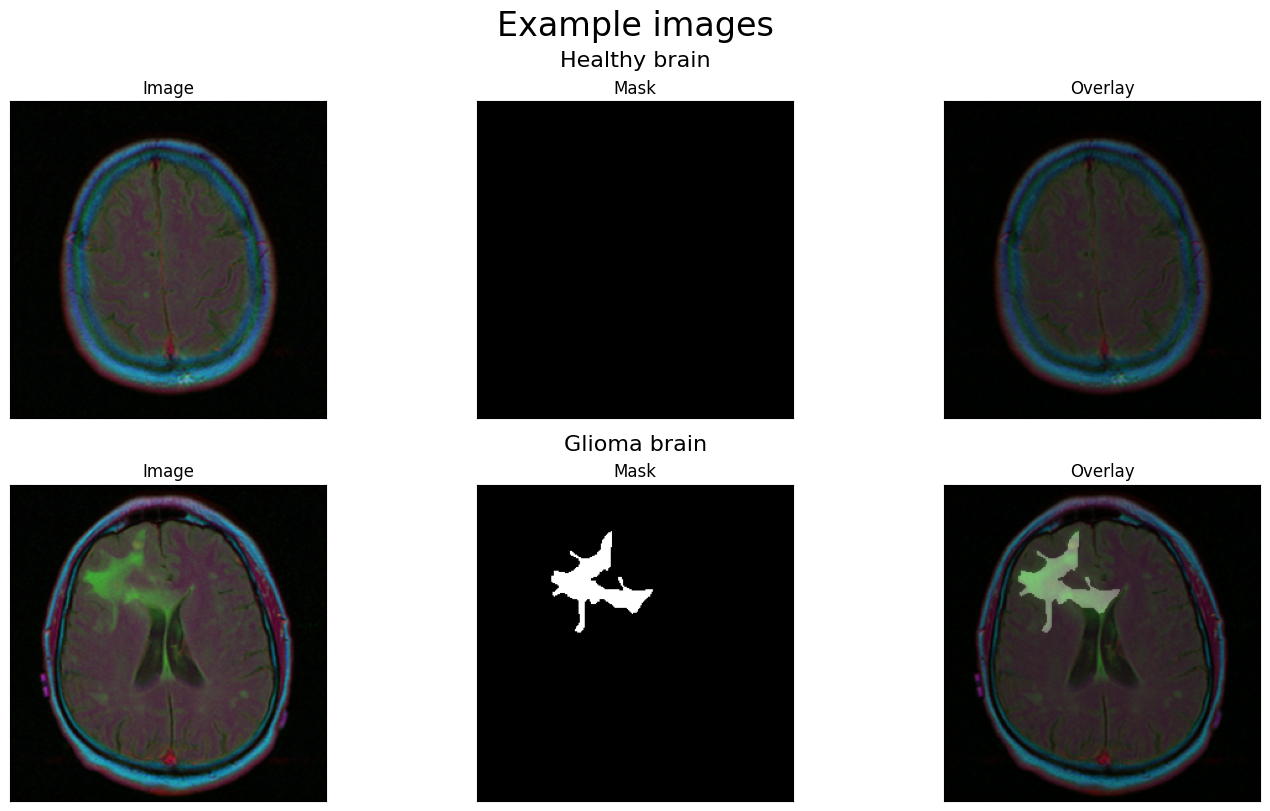

In [2]:
dir = "../dataset/kaggle_3m/TCGA_CS_4941_19960909/"

healthy_image_file = dir + "TCGA_CS_4941_19960909_19.tif"
healthy_mask_file = dir + "TCGA_CS_4941_19960909_19_mask.tif"

tumor_image_file = dir + "TCGA_CS_4941_19960909_15.tif"
tumor_mask_file = dir + "TCGA_CS_4941_19960909_15_mask.tif"

healthy_image = cv.imread(healthy_image_file)
healthy_mask = cv.imread(healthy_mask_file)

tumor_image = cv.imread(tumor_image_file)
tumor_mask = cv.imread(tumor_mask_file)

fig = plt.figure(constrained_layout=True, figsize=(14, 8))
fig.suptitle("Example images", ha="center", fontsize=24, va="top")

subfigs = fig.subfigures(2, 1)

fig1 = subfigs[0]
fig2 = subfigs[1]

healthy_axes = fig1.subplots(1, 3)
tumor_axes = fig2.subplots(1, 3)

fig1.suptitle("Healthy brain", ha="center", fontsize=16, va="top")

for ax in healthy_axes:
    ax.set_xticks([])
    ax.set_yticks([])

for ax in tumor_axes:
    ax.set_xticks([])
    ax.set_yticks([])

healthy_axes[0].title.set_text("Image")
healthy_axes[0].imshow(healthy_image)
healthy_axes[1].title.set_text("Mask")
healthy_axes[1].imshow(healthy_mask)
healthy_axes[2].title.set_text("Overlay")
healthy_axes[2].imshow(healthy_mask)
healthy_axes[2].imshow(healthy_image, alpha=0.7)

fig2.suptitle("Glioma brain", ha="center", fontsize=16, va="top")
tumor_axes[0].title.set_text("Image")
tumor_axes[0].imshow(tumor_image)
tumor_axes[1].title.set_text("Mask")
tumor_axes[1].imshow(tumor_mask)
tumor_axes[2].title.set_text("Overlay")
tumor_axes[2].imshow(tumor_mask)
tumor_axes[2].imshow(tumor_image, alpha=0.7)
plt.show()

In [3]:
MODELS_DIR_PATH = "../models"

def load_model(model_name: str) -> tf.keras.Model:
    return tf.keras.models.load_model(os.path.join(MODELS_DIR_PATH, model_name), custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss, 'iou': iou})

In [4]:
model_0 = load_model("model_0")
model_1 = load_model("model_1")
model_2 = load_model("model_2")

2024-01-09 02:53:50.104354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 02:53:50.121681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 02:53:50.121789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
dataset_loader = DatasetLoaderGen(download=True, resize_shape=(128, 128))
dataest_num_samples = dataset_loader.dataset_info["num_samples"]

steps_per_epoch = (dataest_num_samples - int(dataest_num_samples * 0.7)) // 16
train, valid, test = prepare_dataset(dataset_loader, 16)



100%|██████████| 714M/714M [00:24<00:00, 30.2MB/s] 


### Dobór architektury

W celu rozwiązania zadanego problemu zdecydowano się na wykorzystanie konwolucyjnej sieci neuronowej o architekturze U-Net. Składa się ona z dwóch części: kodera oraz dekodera. Koder jest odpowiedzialny za ekstrakcję cech wyróżniających z obrazu wejściowego, z wykorzystaniem warstw konwolucyjnych oraz próbkujących w dół (MaxPooling). Dekoder natomiast ma za zadanie rzutować cechy rozpoznane przez koder na przestrzeń pikseli o coraz większej rozdzielczości, przy pomocy próbkowania w górę (konwolucja transponowana) oraz konkatenacji. Proponowana architektura została stworzona z myślą rozwiązywania problemów segmentacji obrazów medycznych, z powodzeniem zyskując popularność także w innych dziedzinach, np. implementacja w ArcGIS do klasyfikacji pokrycia terenu.

### Dostosowanie architekury

Charakterystyka rozwiązywanego problemu wymaga segmentacji jednej klasy - zmiany chorobowej (segmentacja binarna). Wejściową rozdzielczością obrazów jest 128x128 pikseli. Przetestowano sieci o czterech oraz pięciu blokach, osiągnęły one najlepsze wyniki.

### Dobór funkcji straty, metryk

Zmiana chorobowa na zdjęciach z zadanego zbioru danych zajmuje przeciętnie niewielki fragment czaszki. Samo tło stanowi około połowę powierzchni obrazu. Mając to na uwadze, należało dobrać metrykę, która będzie odwzorowywać jakość rozpoznania samej zmiany chorobowej. Zdecydowano się na wykorzystanie indeksu Jaccarda (IoU, ang. Intersection over Union), czyli ilorazu mocy części wspólnej zbiorów i mocy sumy tych zbiorów. Metryka ta przyjmuje wartości z zakresu <0, 1>, a im większa jest jej wartość, tym lepsza jakość odwzorowania - 1 oznacza, że zbiory są podobne (w przypadku tego rozwiązania oznacza, że wszystkie piksele klasy pokrywają się). Jako funkcję straty wybrano funkcję opartą o współczynnik Dice'a. Współczynnik ten jest ilorazem podwojonego iloczynu zbiorów i sumy liczb kardynalnych zbiorów, natomiast funkcja straty przyporządkowuje wartości współczynnika wartość do niej przeciwną. Dzięki temu, że współczynnik ten jest oparty o sumę mocy zbiorów, to wymusza on dokładniejsze odwzorowanie kształtu zmiany chorobowej, szczególnie przy glejakach o nieregularnym kształcie figury wklęsłej.

## Porównanie modeli

Skrypt treningowy `train.py` obsługuje parametry sieci neuronowej oraz lokalizację zbioru danych i modelu. 

#### 1. U-Net o 4 blokach i 32 filtrach.

Split zbioru na treningowy, walidacyjny i testowy w stosunku 0.7:0.15:0.15.

<strong>Wyniki ewaluacji:</strong>

Dice loss: -0.37428057193756104

Dice coef: 0.3760364055633545

IOU: 0.29628077149391174

Binary accuracy: 0.9929108023643494

2024-01-09 02:54:25.906100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-09 02:54:25.958521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [16,128,128,3]
	 [[{{node Placeholder/_0}}]]
2024-01-09 02:54:26.567385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


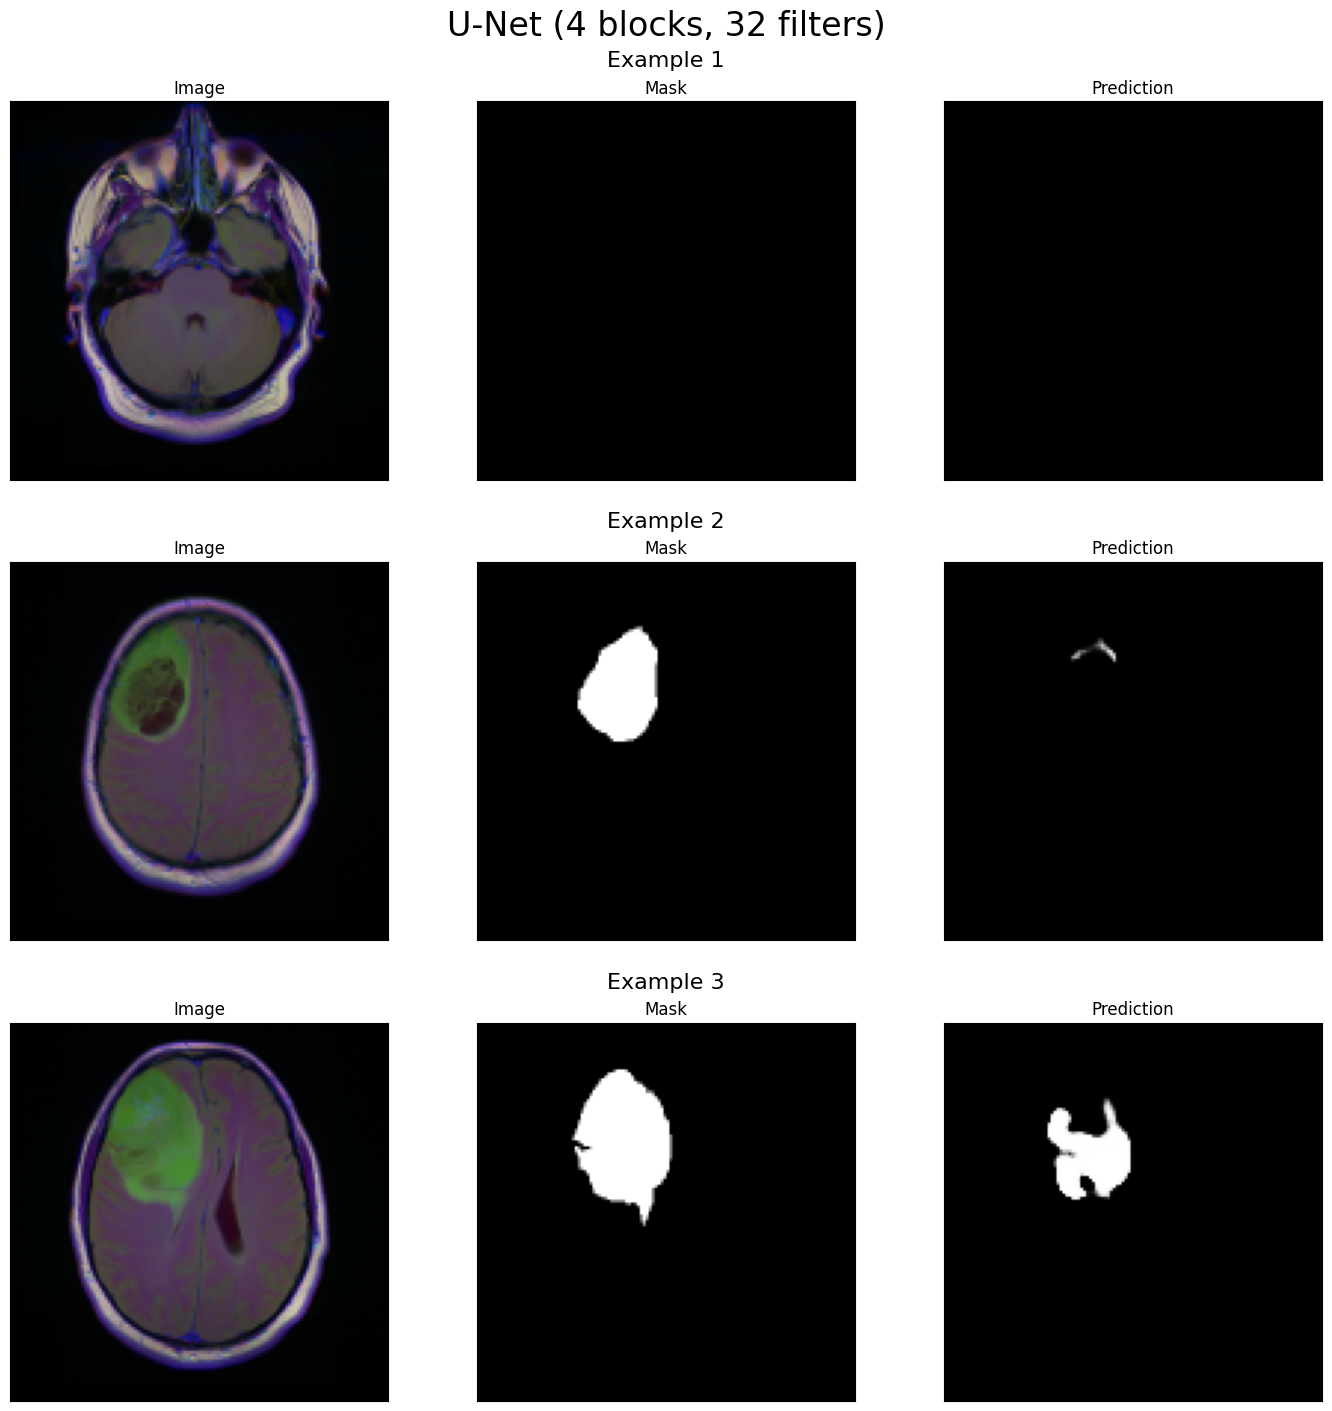

In [6]:
images, masks = next(iter(test))
predictions_0 = model_0.predict_on_batch(images)

plot_prediction(
    images[3:6], masks[3:6], predictions_0[3:6], "U-Net (4 blocks, 32 filters)", 3
)

In [7]:
test_predictions_0 = model_0.predict(test)
test_masks = np.concatenate([y for _, y in test], axis=0)

binarized_predictions = np.where(test_predictions_0.flatten() >= 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(
    tf.cast(test_masks, np.uint8).numpy().flatten(), binarized_predictions
).ravel()

print("True negatives: ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives: ", tp)
print("IOU: ", tp / (tp + fp + fn))

37/37 [==============================] - 2s 57ms/step
True negatives:  9557514
False positives:  2697
False negatives:  61024
True positives:  28941
IOU:  0.3123286784226544


#### 2. U-Net o 4 blokach i 32 filtrach.

Split zbioru na treningowy, walidacyjny i testowy w stosunku 0.6:0.2:0.2.

<strong>Wyniki ewaluacji:</strong>

Dice loss: -0.5318735241889954

Dice coef: 0.5323854684829712

IOU: 0.4384137690067291

Binary accuracy: 0.9925440549850464

2024-01-09 02:54:31.668378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [16,128,128,3]
	 [[{{node Placeholder/_0}}]]


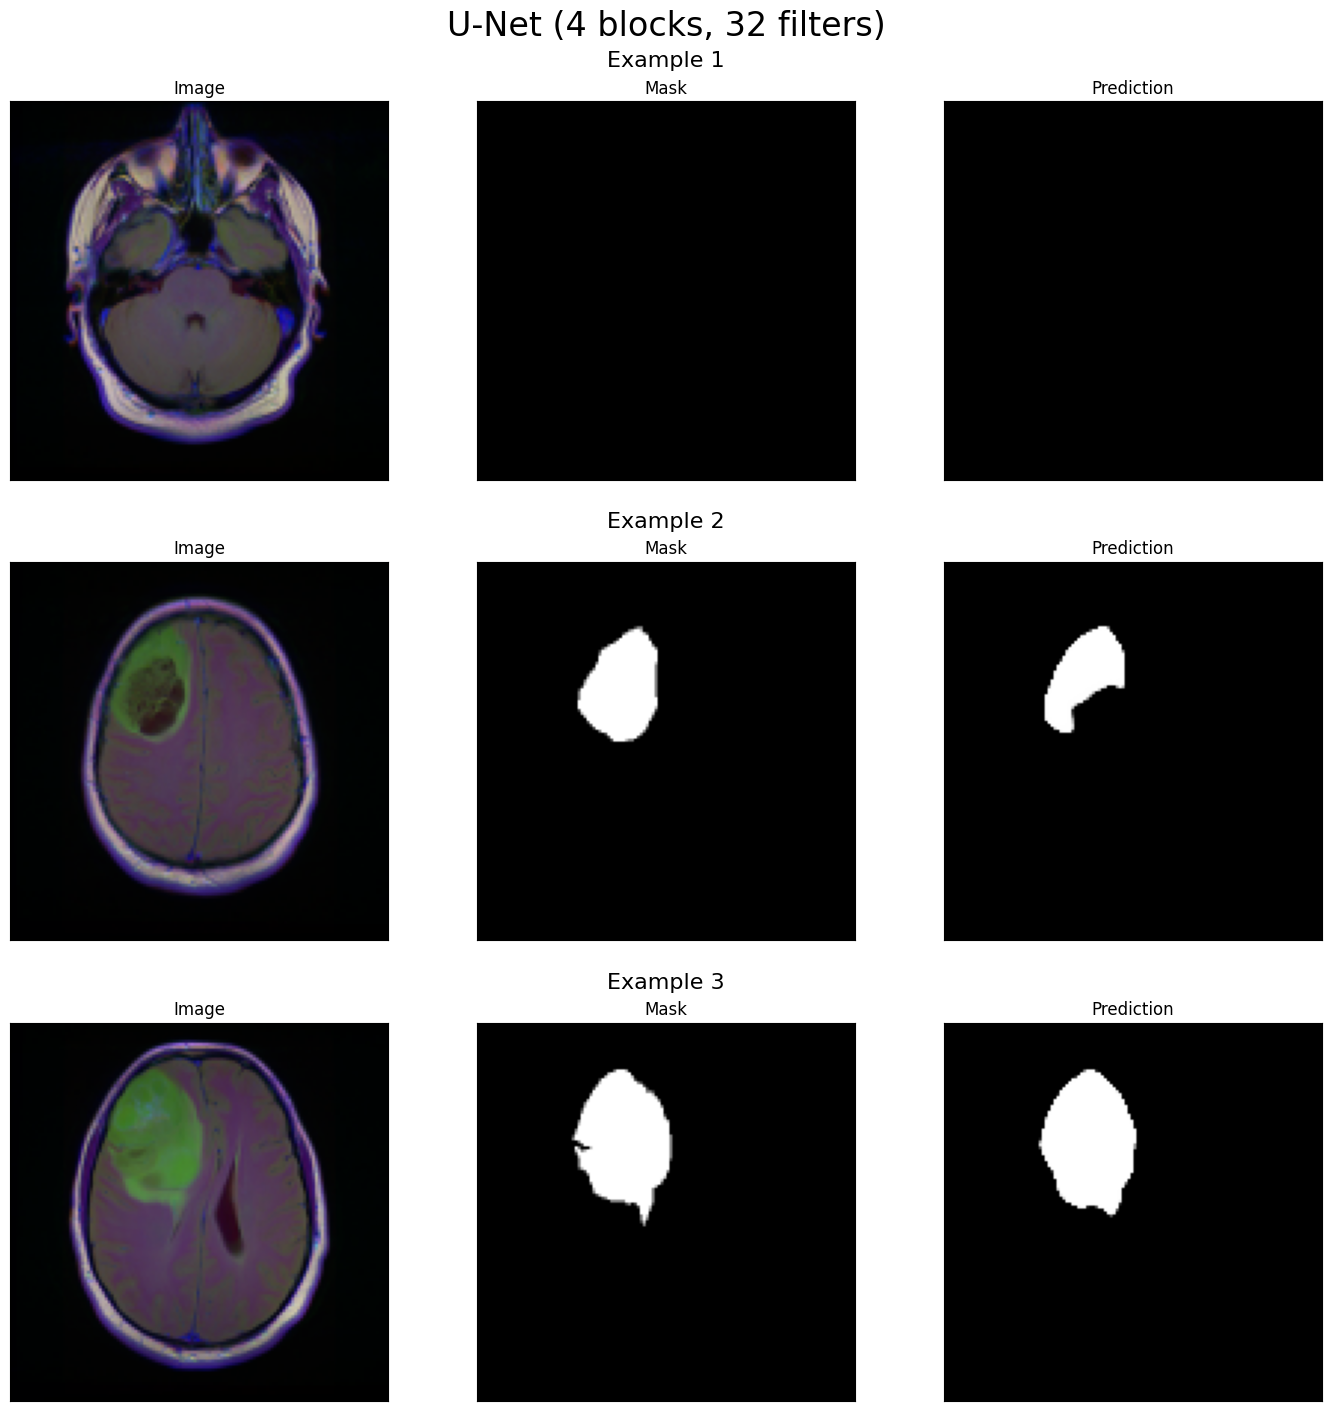

In [8]:
predictions_1 = model_1.predict_on_batch(images)

plot_prediction(
    images[3:6], masks[3:6], predictions_1[3:6], "U-Net (4 blocks, 32 filters)", 3
)

In [9]:
test_predictions_1 = model_1.predict(test)

binarized_predictions = np.where(test_predictions_1.flatten() >= 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(
    tf.cast(test_masks, np.uint8).numpy().flatten(), binarized_predictions
).ravel()

print("True negatives: ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives: ", tp)
print("IOU: ", tp / (tp + fp + fn))

37/37 [==============================] - 2s 45ms/step
True negatives:  9528076
False positives:  32135
False negatives:  18766
True positives:  71199
IOU:  0.5831203931203931


#### 3. U-Net o 5 blokach i 32 filtrach.

Split zbioru na treningowy, walidacyjny i testowy w stosunku 0.7:0.15:0.15.

<strong>Wyniki ewaluacji: </strong>

Dice loss: -0.4942633807659149

Dice coef: 0.49517661333084106

IOU: 0.40483254194259644

Binary accuracy: 0.9936534762382507

2024-01-09 02:54:34.594795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [16,128,128,3]
	 [[{{node Placeholder/_0}}]]


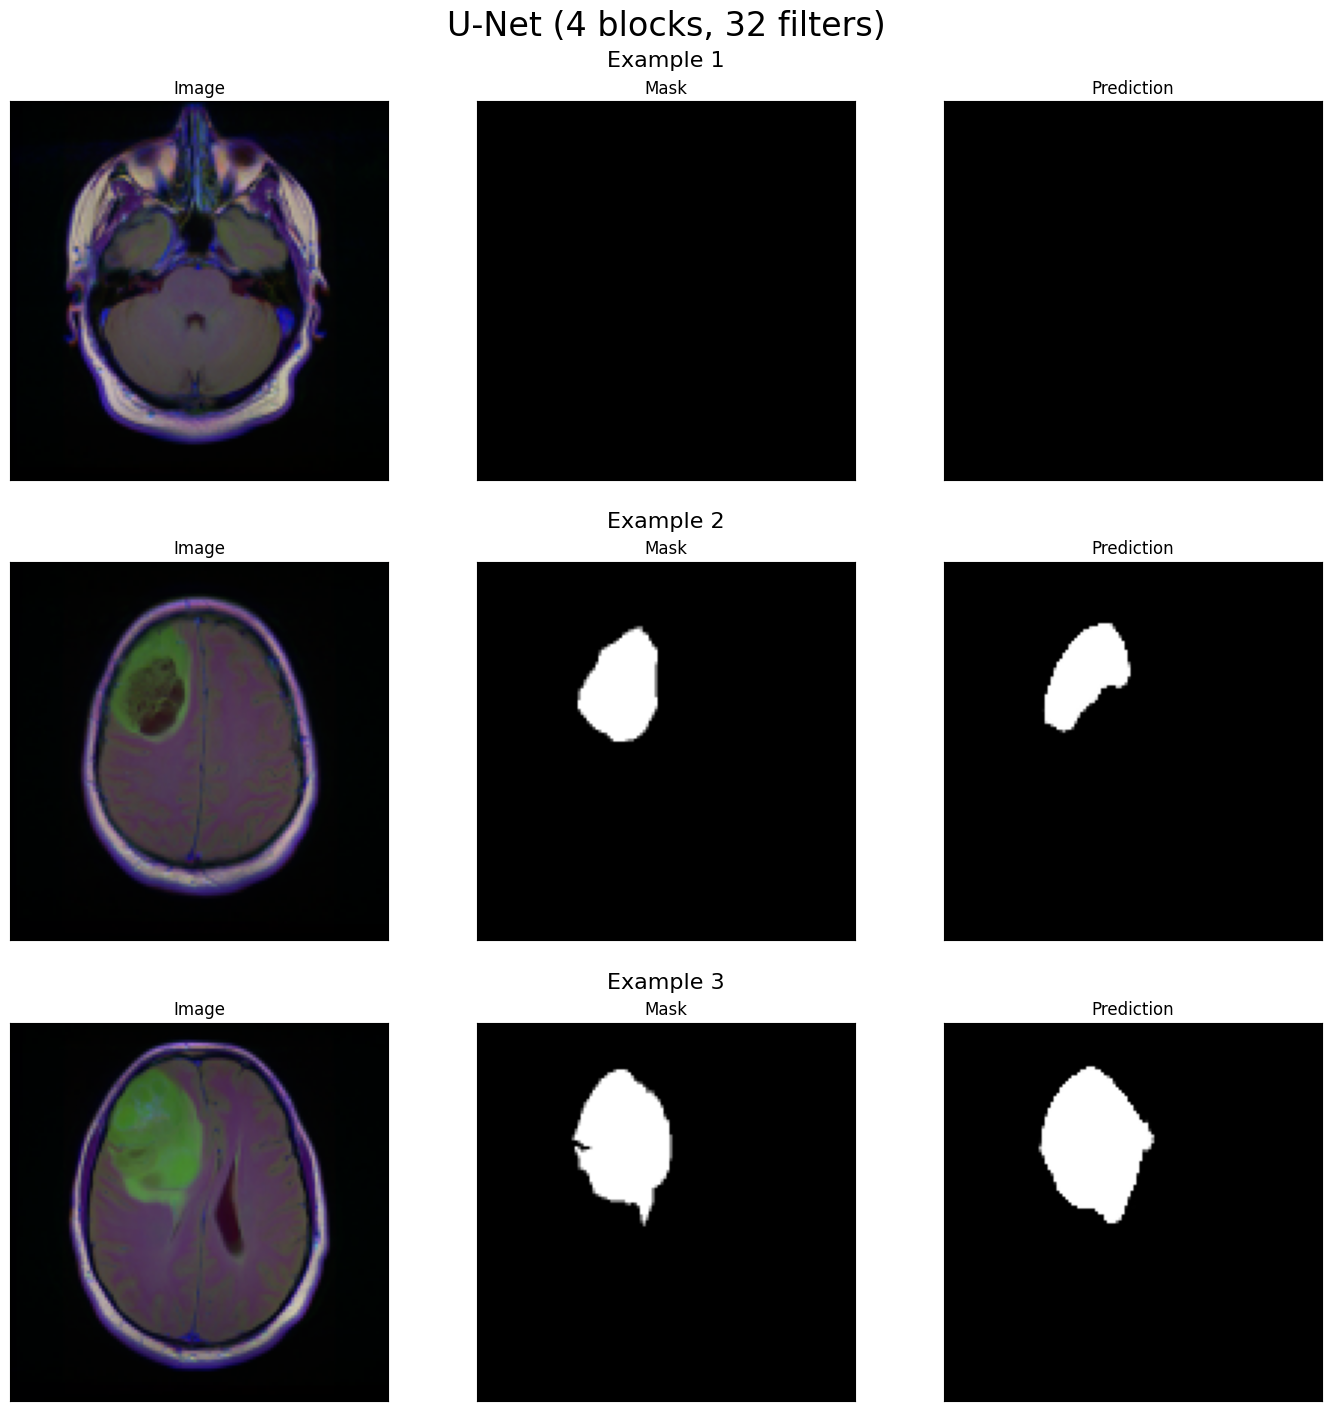

In [10]:
predictions_2 = model_2.predict_on_batch(images)

plot_prediction(
    images[3:6], masks[3:6], predictions_2[3:6], "U-Net (4 blocks, 32 filters)", 3
)

In [11]:
test_predictions_2 = model_2.predict(test)

binarized_predictions = np.where(test_predictions_2.flatten() >= 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(
    tf.cast(test_masks, np.uint8).numpy().flatten(), binarized_predictions
).ravel()

print("True negatives: ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives: ", tp)
print("IOU: ", tp / (tp + fp + fn))

37/37 [==============================] - 2s 51ms/step
True negatives:  9543597
False positives:  16614
False negatives:  30943
True positives:  59022
IOU:  0.5537863931919046


## Wnioski

Najlepszy wynik został osiągnięty przy większym zbiorze walidacyjnym. Ponadto, zaobserwowano wyższe wartości metryk dla modeli o większej liczbie bloków. Wszystkie modele charakteryzują się niską liczbą przypadków <em>false negative</em>, co pozwala łatwo sklasyfikować pacjentów zdrowych. Zmiany chorobowe są poprawnie wykrywane przynajmniej w ich znaczącej części - IOU powyżej 0.5.